In [1]:
import pandas as pd
import os
import sys
import requests

#sys.path.append(os.path.abspath("../../src"))
from vayu_gnn.dbx.dbx_config import dbx_helper, DropboxHelper

In [9]:
import requests
import pandas as pd
from io import StringIO

def fetch_sensor_data(write = True, output_dict=True):
    # API endpoint and headers
    url = "https://vayuapi.undp.org.in/device/api/v1/sensor-data-download"
    headers = {
        "accept": "application/json",
        "Content-Type": "application/json"
    }
    
    # Define the period: from June 2024 through February 2025
    months_years = [
        ("June", "2024"),
        ("July", "2024"),
        ("August", "2024"),
        ("September", "2024"),
        ("October", "2024"),
        ("November", "2024"),
        ("December", "2024"),
        ("January", "2025"),
        ("February", "2025")
    ]
    
    # Define the cities and device types
    cities = ["Gurugram"]
    device_types = ["static", "dynamic"]
    
    # cities = ["Patna"]
    # device_types = ["static"]
    
    # Dictionary to store the final dataframes
    result_dfs = {}
    
    # Loop through each city and device type
    for city in cities:
        for device_type in device_types:
            monthly_dfs = []  # List to hold dataframes for each month
            for month, year in months_years:
                print(f"Fetching data for {city}, {device_type} for {month} {year}")
                
                # Prepare payload for the API call
                payload = {
                    "month": month,
                    "year": year,
                    "city": city,
                    "device_type": device_type
                }
                response = requests.post(url, headers=headers, json=payload)
                
                if response.status_code == 200:
                    data = response.json()
                    if data.get("success"):
                        download_link = data.get("data")
                        csv_response = requests.get(download_link)
                        if csv_response.status_code == 200:
                            # Convert the CSV content to a dataframe
                            csv_content = csv_response.content.decode('utf-8')
                            df = pd.read_csv(StringIO(csv_content), dtype={'lat':'Float64','long':'Float64'}, engine='pyarrow', na_values = ' ', keep_default_na=True)
                            monthly_dfs.append(df)
                        else:
                            print(f"Failed to download CSV for {city}, {device_type} for {month} {year}. Status code: {csv_response.status_code}")
                    else:
                        print(f"API error for {city}, {device_type} for {month} {year}: {data.get('message')}")
                else:
                    print(f"HTTP error for {city}, {device_type} for {month} {year}: {response.status_code}")
            
            # Concatenate all the monthly dataframes if any data was retrieved
            if monthly_dfs:
                concatenated_df = pd.concat(monthly_dfs, ignore_index=True)
            else:
                concatenated_df = pd.DataFrame()  # Empty dataframe if no data
            
            # Save the concatenated dataframe under a key like "Patna_static"
            if write:
                dbx_helper.write_parquet(concatenated_df, '/input', 'raw',f'sensor/{city}_{device_type}.parquet')
            if output_dict:
                result_dfs[f'{city}_{device_type}'] = concatenated_df

    return result_dfs

# Execute the function to get the four dataframes
dfs = fetch_sensor_data()

Fetching data for Gurugram, static for June 2024


ParserError: Empty CSV file

In [3]:
patna_static = dbx_helper.read_parquet('/input/raw', 'sensor', 'Patna_static.parquet')

File 'Patna_static.parquet' successfully downloaded and loaded into a DataFrame.


In [ ]:
patna_static.query(' device_name == "TARA012" & ~lat.isna()').query('lat > 1 & long > 1 & ').sort_values('lat').tail(10)

,id,device_name,lat,long,pm_25,pm_10,no2,co,co2,ch4,temp,rh,data_created_time
945993,1891822,TARA012,25356.367,85.113716,57.8,78.1,154.0,NaN,NaN,120112.0,34.8,62.0,2024-08-08 11:12:00+00:00
945872,1891598,TARA012,25356.367,85.113716,57.5,77.7,154.0,NaN,NaN,120112.0,34.6,62.0,2024-08-08 11:07:00+00:00
946018,1891868,TARA012,25356.367,85.113716,59.0,79.7,154.0,NaN,NaN,120112.0,34.8,62.0,2024-08-08 11:13:00+00:00
945675,1891233,TARA012,25356.367,85.113716,64.5,87.2,154.0,NaN,NaN,120112.0,34.5,64.0,2024-08-08 10:59:00+00:00
945896,1891642,TARA012,25356.367,85.113716,58.4,79.0,154.0,NaN,NaN,120112.0,34.6,61.0,2024-08-08 11:08:00+00:00
945919,1891684,TARA012,25356.367,85.113716,58.4,79.0,154.0,NaN,NaN,120112.0,34.6,61.0,2024-08-08 11:09:00+00:00
945943,1891729,TARA012,25356.367,85.113716,58.4,79.0,154.0,NaN,NaN,120112.0,34.6,61.0,2024-08-08 11:10:00+00:00
946044,1891916,TARA012,25356.367,85.113716,60.4,81.6,154.0,NaN,NaN,120112.0,34.9,62.0,2024-08-08 11:14:00+00:00
945798,1891459,TARA012,25356.367,85.113716,58.3,78.8,154.0,NaN,NaN,120112.0,34.7,63.0,2024-08-08 11:04:00+00:00
945820,1891503,TARA012,25356.367,85.113716,56.6,76.5,154.0,NaN,NaN,120112.0,34.7,63.0,2024-08-08 11:05:00+00:00


In [46]:
patna_static.query('lat > 5 & long > 5 & lat < 26 & long <90 ').groupby('device_name').agg({'lat':'median','long':'median'}).to_dict(orient='index')

{'TARA012': {'lat': 25.599453, 'long': 85.113747},
 'TARA013': {'lat': 25.606956, 'long': 85.16494},
 'TARA016': {'lat': 25.578144, 'long': 85.056877},
 'TARA017': {'lat': 25.622419, 'long': 85.091644},
 'TARA018': {'lat': 25.582685, 'long': 85.097473},
 'TARA019': {'lat': 25.56951, 'long': 85.179916},
 'TARA021': {'lat': 25.610348, 'long': 85.132942},
 'TARA022': {'lat': 25.619711, 'long': 85.147354},
 'TARA025': {'lat': 25.61482, 'long': 85.099258},
 'TARA026': {'lat': 25.636131, 'long': 85.10482},
 'TARA027': {'lat': 25.626888, 'long': 85.122955},
 'TARA028': {'lat': 25.58654, 'long': 85.044319},
 'TARA030': {'lat': 25.588337, 'long': 85.166382},
 'TARA031': {'lat': 25.596865, 'long': 85.085609},
 'TARA032': {'lat': 25.619537, 'long': 85.126167},
 'TARA035': {'lat': 25.617426, 'long': 85.079117},
 'TARA043': {'lat': 25.600891, 'long': 85.125664},
 'TARA047': {'lat': 25.586817, 'long': 85.249748},
 'TARA048': {'lat': 25.566462, 'long': 85.263992},
 'TARA049': {'lat': 25.61499, 'long'

In [39]:
dbx_helper.write_pickle(
    patna_static.query('lat > 5 & long > 5 & lat < 26 & long <90 ').groupby('device_name').agg({'lat':'median','long':'median'}).to_dict(orient='index'),
    '/input/clean', 'map_device_to_latlong', 'Patna_static.pickle'
)


File 'Patna_static.pickle' successfully uploaded to Dropbox path: '/input/clean/map_device_to_latlong/Patna_static.pickle'


In [51]:
patna_static.query('lat > 5 & long > 5 & long <90 & lat < 30 ').groupby('device_name').agg({'lat':['median','std'],'long':['median','std']}).sort_values(('long','std'), ascending=False).head()

lat                 long          
                median       std     median       std
device_name                                          
TARA031      25.596869  0.213177  85.085602  4.986587
TARA061      25.601467  0.181333  85.146797  4.826461
TARA026      25.636131  0.200285   85.10482   4.73574
TARA099      25.610893  0.073918  85.201241  3.616117
TARA043      25.600893   0.12171  85.125664  3.450805

In [52]:
patna_static.query('lat > 5 & long > 5 & lat < 30 & long <90')

,id,device_name,lat,long,pm_25,pm_10,no2,co,co2,ch4,temp,rh,data_created_time
0,239481,TARA052,25.61499,85.055794,36.8,70.5,50.30,NaN,416.0,NaN,39.9,37.0,2024-06-24 17:24:00+00:00
1,241245,TARA052,25.61524,85.055717,42.7,55.9,25.30,NaN,429.0,NaN,37.4,52.0,2024-06-24 22:31:00+00:00
2,243010,TARA052,25.614872,85.055786,56.1,58.6,11.30,NaN,431.0,NaN,36.1,58.0,2024-06-25 02:48:00+00:00
3,244774,TARA016,25.600853,85.125,65.8,89.0,31.00,1.04,NaN,NaN,35.6,58.0,2024-06-25 07:13:00+00:00
4,246538,TARA016,25.601017,85.125557,79.4,107.4,32.60,0.24,NaN,NaN,35.2,60.0,2024-06-25 18:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7129040,14971568,TARA025,25.614811,85.099281,158.2,213.8,768.00,1.00,NaN,NaN,26.0,58.0,2025-02-28 23:59:00+00:00
7129041,14971570,TARA019,25.569511,85.179901,241.9,326.9,352.00,NaN,NaN,2.15,26.0,55.0,2025-02-28 23:59:00+00:00
7129042,14971572,TARA026,25.63616,85.104813,239.6,323.8,25.17,1.52,NaN,NaN,27.4,51.0,2025-02-28 23:59:00+00:00
7129043,14971575,TARA028,25.586519,85.044395,246.2,332.7,23.00,NaN,NaN,2.03,25.0,63.0,2025-02-28 23:59:00+00:00


In [57]:
patna_static.query('device_name == "TARA021"')[['lat','long']].round(2).value_counts(normalize=True).round(2)

lat    long   
26.51  80.27      0.91
25.61  85.13      0.07
26.51  80.28      0.01
       8016.03    0.01
       1.33       0.00
3.05   5.13       0.00
26.51  0.15       0.00
       801.03     0.00
       0.04       0.00
0.03   80.27      0.00
26.51  0.13       0.00
       0.0        0.00
       8.03       0.00
       0.17       0.00
Name: proportion, dtype: float64

In [4]:
df = dataframes['Patna_static'].copy()

In [8]:
df.groupby('device_name').agg({'lat':'mean','long':'mean'})

,lat,long
device_name,,
TARA012,71.445245,87.287498
TARA013,34.474229,90.722639
TARA016,25.599614,84.899314
TARA017,25.625499,85.060944
TARA018,42.307698,107.314248
TARA019,25.555414,85.304153
TARA022,26.071207,86.367102
TARA025,30.798961,90.112408
TARA026,25.825999,84.874528


In [9]:
df

,id,device_name,lat,long,pm_25,pm_10,no2,co,co2,ch4,temp,rh,data_created_time
0,7144596,TARA025,25.614836,85.099266,186.4,251.9,350.00,1.02,NaN,NaN,30.6,62.0,2024-11-01 00:00:00+00:00
1,7144598,TARA018,25.582617,85.097557,246.9,297.9,4.07,NaN,NaN,101113.0,32.8,53.0,2024-11-01 00:00:00+00:00
2,7144602,TARA043,25.600906,85.125725,227.8,338.4,NaN,NaN,NaN,NaN,0.0,0.0,2024-11-01 00:00:00+00:00
3,7144604,TARA062,25.614395,85.104324,229.9,310.7,540.00,NaN,NaN,NaN,32.5,56.0,2024-11-01 00:00:00+00:00
4,7144606,TARA019,25.569618,85.179825,173.5,234.4,439.17,NaN,NaN,NaN,31.1,57.0,2024-11-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074991,11756158,TARA017,25.622383,85.091606,168.3,227.5,119.00,NaN,434.0,NaN,17.0,62.0,2024-12-31 23:59:00+00:00
2074992,11756159,TARA064,25.631615,85.115936,134.9,182.3,22.17,1.01,NaN,NaN,18.2,58.0,2024-12-31 23:59:00+00:00
2074993,11756163,TARA047,0.500000,9.218345,151.0,204.1,40.50,NaN,403.0,NaN,20.6,49.0,2024-12-31 23:59:00+00:00
2074994,11756165,TARA099,25.610830,85.201233,116.9,158.0,6.00,1.64,NaN,NaN,17.8,58.0,2024-12-31 23:59:00+00:00


In [40]:
# Create a single column
dataframes['Patna_static']['lat_lon'] = list(zip(dataframes['Patna_static'].lat, dataframes['Patna_static'].long))
dataframes['Patna_static'].head()

,id,device_name,lat,long,pm_25,pm_10,no2,co,co2,ch4,temp,rh,data_created_time,lat_lon
0,239481,TARA052,25.614990,85.055794,36.8,70.5,50.3,NaN,416.0,NaN,39.9,37.0,2024-06-24 17:24:00+00:00,"(25.614990, 85.055794)"
1,241245,TARA052,25.615240,85.055717,42.7,55.9,25.3,NaN,429.0,NaN,37.4,52.0,2024-06-24 22:31:00+00:00,"(25.615240, 85.055717)"
2,243010,TARA052,25.614872,85.055786,56.1,58.6,11.3,NaN,431.0,NaN,36.1,58.0,2024-06-25 02:48:00+00:00,"(25.614872, 85.055786)"
3,244774,TARA016,25.600853,85.125000,65.8,89.0,31.0,1.04,NaN,NaN,35.6,58.0,2024-06-25 07:13:00+00:00,"(25.600853, 85.125000)"
4,246538,TARA016,25.601017,85.125557,79.4,107.4,32.6,0.24,NaN,NaN,35.2,60.0,2024-06-25 18:00:00+00:00,"(25.601017, 85.125557)"


It seems that  2% of observations have NAs

In [44]:
dataframes['Patna_static']['lat'].isna().mean().round(3)

np.float64(0.02)

A certain number of observations have lat/longs coded as " ". Perhaps the TARA 099 is a specific device which doesn't have a lat/long? not sure.

In [53]:
dataframes['Patna_static'].query('lat == " "')

,id,device_name,lat,long,pm_25,pm_10,no2,co,co2,ch4,temp,rh,data_created_time,lat_lon
70,267703,TARA099,,,29.7,32.1,72.0,0.97,NaN,NaN,35.0,58.0,2024-06-28 09:17:00+00:00,"( , )"
351,267801,TARA099,,,26.3,39.5,72.0,0.96,NaN,NaN,35.4,56.0,2024-06-28 09:27:00+00:00,"( , )"
699,267813,TARA099,,,26.3,39.5,72.0,0.90,NaN,NaN,35.4,56.0,2024-06-28 09:28:00+00:00,"( , )"
1018,267824,TARA099,,,26.3,39.5,72.0,0.95,NaN,NaN,35.5,56.0,2024-06-28 09:29:00+00:00,"( , )"
1311,267834,TARA099,,,26.3,39.5,72.0,0.96,NaN,NaN,35.5,56.0,2024-06-28 09:31:00+00:00,"( , )"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153087,267676,TARA099,,,25.8,28.3,72.0,0.96,NaN,NaN,34.9,58.0,2024-06-28 09:13:00+00:00,"( , )"
153278,267467,TARA099,,,28.5,38.5,78.9,0.93,NaN,NaN,34.1,62.0,2024-06-28 08:48:00+00:00,"( , )"
153566,267477,TARA099,,,27.5,37.1,78.9,0.93,NaN,NaN,34.1,61.0,2024-06-28 08:49:00+00:00,"( , )"
154056,267694,TARA099,,,29.7,32.1,72.0,0.96,NaN,NaN,35.0,58.0,2024-06-28 09:16:00+00:00,"( , )"


There are a certain number of censor device types:

In [49]:
dataframes['Patna_static'].device_name.nunique()

31

A question I have is this- shouldn't there be an id for a device at a specific lat/long? I think device name is more like sensor type, and it would be great if there was a variable which referred to a unit/entity, but it doesn't look like there is.

I will create a location id and examine if it is consistently represented over time.

In [60]:
dataframes['Patna_static']['location_id'] = pd.factorize(dataframes['Patna_static'].lat_lon)[0]
dataframes['Patna_static']['data_created_time'] = pd.to_datetime(dataframes['Patna_static']['data_created_time'])

In [64]:

print(f'number of unique location ids: {dataframes['Patna_static'].location_id.nunique()}')

number of unique location ids: 243295


In [68]:
dataframes['Patna_static'].query(f'location_id == {36675}')

,id,device_name,lat,long,pm_25,pm_10,no2,co,co2,ch4,temp,rh,data_created_time,lat_lon,location_id
286488,643522,TARA030,25.588472,85.166374,22.8,33.5,983.80,2.16,NaN,NaN,36.3,55.0,2024-07-20 09:53:00+00:00,"(25.588472, 85.166374)",36675
630782,1280669,TARA030,25.588472,85.166374,50.8,68.6,700.27,2.19,NaN,NaN,36.1,59.0,2024-07-30 08:36:00+00:00,"(25.588472, 85.166374)",36675
953570,1905569,TARA030,25.588472,85.166374,50.5,68.3,141.03,1.07,NaN,NaN,34.6,59.0,2024-08-08 16:25:00+00:00,"(25.588472, 85.166374)",36675
953713,1905838,TARA030,25.588472,85.166374,48.6,65.7,120.73,1.08,NaN,NaN,34.6,61.0,2024-08-08 16:31:00+00:00,"(25.588472, 85.166374)",36675
957762,1913344,TARA030,25.588472,85.166374,84.6,114.3,37.00,1.57,NaN,NaN,33.4,64.0,2024-08-08 19:16:00+00:00,"(25.588472, 85.166374)",36675
1055976,2095663,TARA030,25.588472,85.166374,31.8,43.0,53.57,2.12,NaN,NaN,34.3,61.0,2024-08-11 15:53:00+00:00,"(25.588472, 85.166374)",36675
1433622,2801020,TARA030,25.588472,85.166374,26.1,35.3,353.03,1.20,NaN,NaN,33.6,65.0,2024-08-22 23:48:00+00:00,"(25.588472, 85.166374)",36675
1767699,3409656,TARA030,25.588472,85.166374,25.8,34.9,113.50,1.18,NaN,NaN,34.2,64.0,2024-09-01 23:39:00+00:00,"(25.588472, 85.166374)",36675
2606256,4941570,TARA030,25.588472,85.166374,15.1,20.4,62.00,1.80,NaN,NaN,31.5,69.0,2024-09-26 10:08:00+00:00,"(25.588472, 85.166374)",36675
2979800,5671895,TARA030,25.588472,85.166374,143.6,187.3,49.50,1.15,NaN,NaN,34.1,53.0,2024-10-08 16:23:00+00:00,"(25.588472, 85.166374)",36675


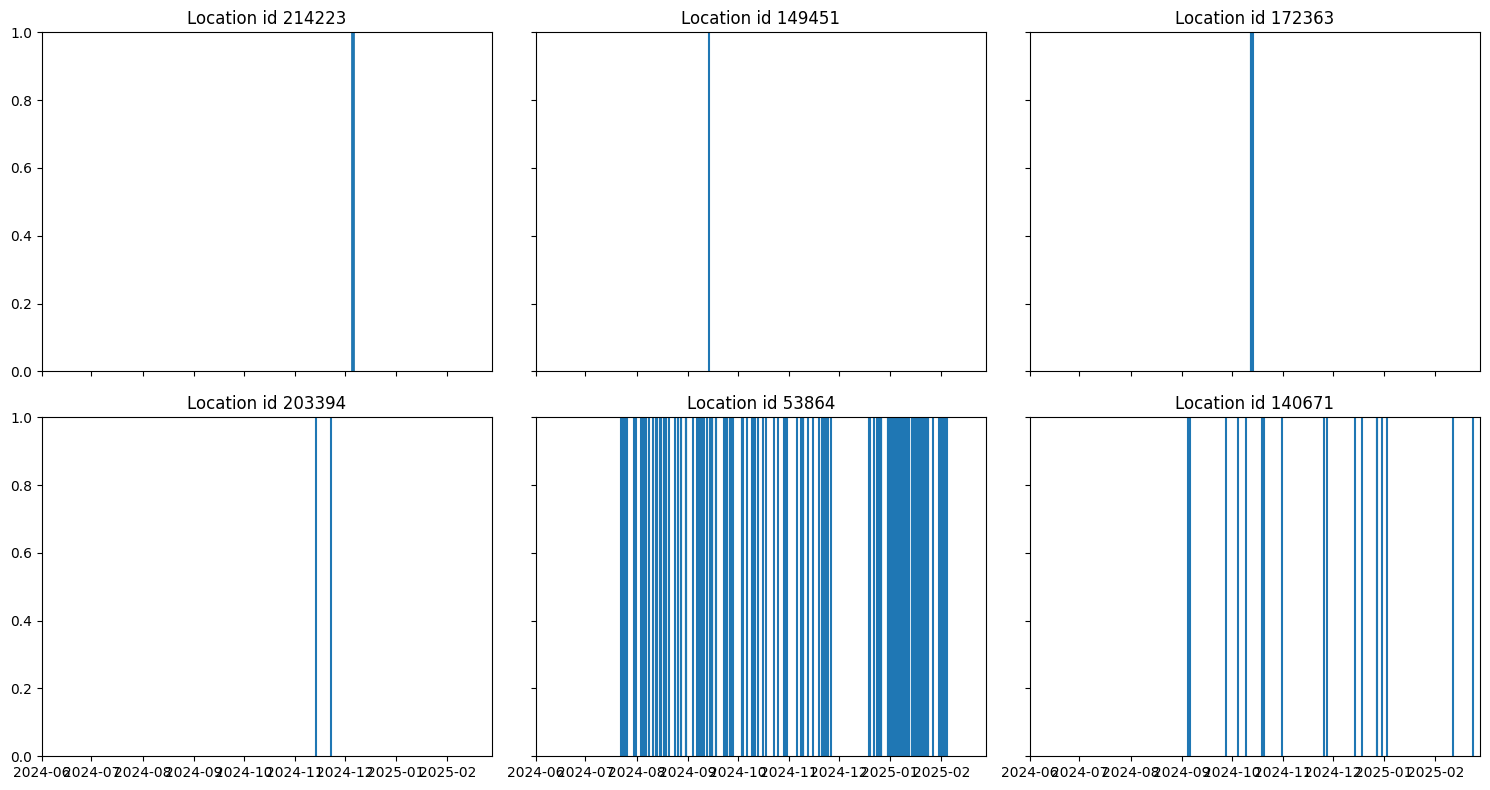

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

np.random.seed(1)
loc_ids = np.random.choice(dataframes['Patna_static'].location_id.unique(), 6, replace=False)

# Calculate the grid size
num_plots = len(loc_ids)
cols = 3  # Fixed number of columns
rows = (num_plots + cols - 1) // cols  # Calculate rows needed

# Define fixed x-axis limits
min_date = datetime(2024, 6, 1)
max_date = datetime(2025, 2, 28)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily iterate over

for i, id in enumerate(loc_ids):
    subset = dataframes['Patna_static'].query(f'location_id == {id}').copy()

    # Plotting on the corresponding subplot
    ax = axes[i]
    for date in subset.data_created_time:
        ax.axvline(x=date, ymin=0, ymax=1)
    
    ax.set_xlim(min_date, max_date)  # Set fixed x-axis limits
    ax.set_title(f'Location id {id}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Hmm this doesn't look good. These static sensors are not consistent in their measurements. I wonder if pollution levels are correlated with their frequency?

What is the usual amount of time between measurements?

In [103]:
# 
df = dataframes['Patna_static'].copy()

df.sort_values(['location_id','data_created_time'], inplace=True)
df['seconds_between_readings'] = df.groupby('location_id').data_created_time.transform('diff').dt.seconds

In [106]:
df['minutes_between_readings'] = df['seconds_between_readings']/ 60

In [129]:
!poetry add seaborn

Using version ^0.13.2 for seaborn

Updating dependencies
Resolving dependencies... (1.0s)

Package operations: 1 install, 0 updates, 0 removals

  - Installing seaborn (0.13.2): Pending...
  - Installing seaborn (0.13.2): Installing...
  - Installing seaborn (0.13.2)

Writing lock file


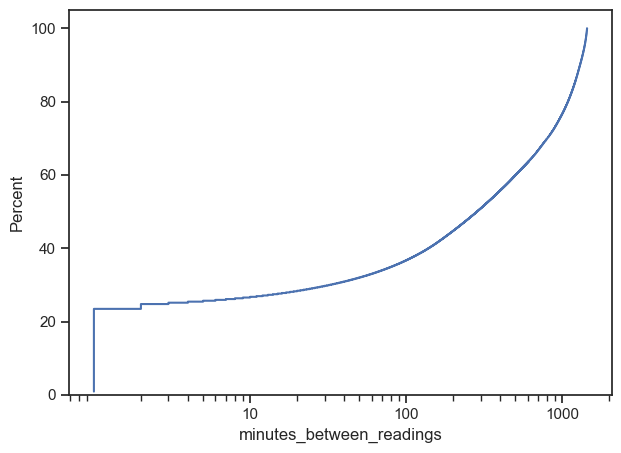

In [142]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 5))

sns.ecdfplot(df, x='minutes_between_readings', log_scale=True, stat='percent')
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 100, 1000])


20% observations take place within seconds of each other, while the rest may take anywhere between a couple minutes to a day.

Is the amount of time between readings consistent in terms of each location?

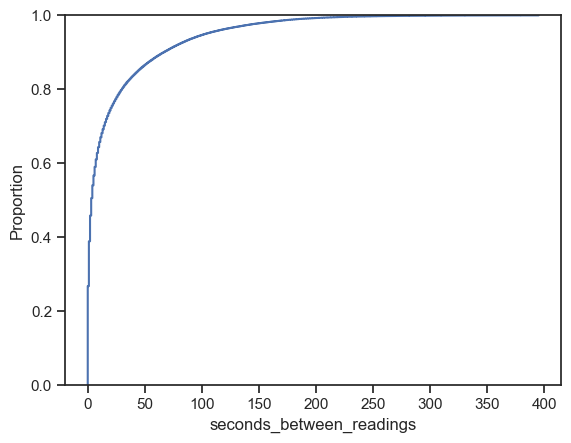

<Axes: xlabel='seconds_between_readings', ylabel='Proportion'>

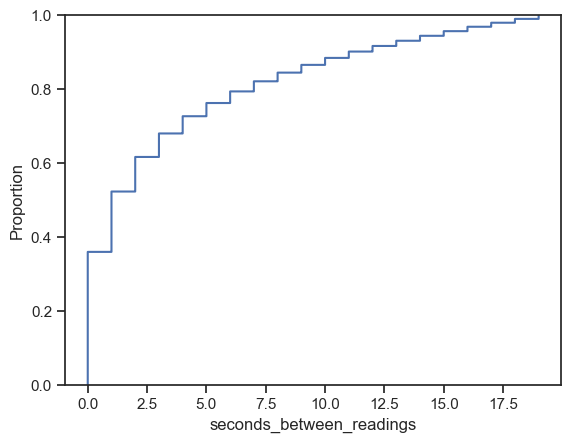

In [161]:

sns.ecdfplot(df.groupby('location_id').seconds_between_readings.nunique().to_frame(), x='seconds_between_readings')
plt.show()

# Zoom in on the main  <20 group.
sns.ecdfplot(df.groupby('location_id').seconds_between_readings.nunique().to_frame().query('seconds_between_readings < 20'), x='seconds_between_readings')

Most are fairly consistent with only a few number of unique amounts of time between readings, the rest seem to be quite inconsistent. There may be a better way to examine this.

### Are both dynamic and static sensors at sensical lat and longs?

In [13]:
df.query('long == 0')

,id,device_name,lat,long,pm_25,pm_10,no2,co,co2,ch4,temp,rh,data_created_time
803,7146325,TARA019,25.569654,0.0,164.0,221.6,429.13,NaN,NaN,NaN,30.7,58.0,2024-11-01 00:33:00+00:00
1845,7148605,TARA061,25.601442,0.0,195.6,248.4,5.10,0.93,NaN,NaN,30.2,57.0,2024-11-01 01:17:00+00:00
1869,7148656,TARA061,25.601442,0.0,196.1,234.8,5.10,0.92,NaN,NaN,30.2,57.0,2024-11-01 01:18:00+00:00
1895,7148708,TARA061,25.601442,0.0,174.7,240.7,5.10,0.93,NaN,NaN,30.2,57.0,2024-11-01 01:19:00+00:00
1920,7148758,TARA061,25.601442,0.0,183.2,232.6,5.10,0.93,NaN,NaN,30.2,57.0,2024-11-01 01:20:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074661,11755445,TARA027,25.626823,0.0,152.8,206.5,11.50,NaN,429.0,NaN,17.2,64.0,2024-12-31 23:46:00+00:00
2074685,11755497,TARA027,25.626823,0.0,153.2,207.0,11.50,NaN,427.0,NaN,17.2,64.0,2024-12-31 23:47:00+00:00
2074706,11755548,TARA027,25.626823,0.0,152.5,206.1,11.50,NaN,425.0,NaN,17.1,64.0,2024-12-31 23:48:00+00:00
2074731,11755602,TARA027,25.626823,0.0,163.7,221.2,11.50,NaN,427.0,NaN,17.1,64.0,2024-12-31 23:49:00+00:00


In [24]:
df.groupby('device_name').agg({'lat':'median','long':'median'})

,lat,long
device_name,,
TARA012,25.599457,85.113747
TARA013,25.606962,85.164940
TARA016,25.578133,85.056870
TARA017,25.622404,85.091644
TARA018,25.582699,85.097466
TARA019,25.569523,85.179924
TARA022,25.619711,85.147354
TARA025,25.614826,85.099258
TARA026,25.636137,85.104820


In [ ]:
# the latitude for gurugram should be 28
# the longitude for gurugram should be between 76 and 77
# the latitude for patna should be 25
# The longitude for patna should be 85

df.query('(lat < 25) | (lat > 26) ')

,id,device_name,lat,long,pm_25,pm_10,no2,co,co2,ch4,temp,rh,data_created_time
143,7144906,TARA025,0.033367,0.100000,174.5,235.8,350.0,0.59,NaN,NaN,30.5,62.0,2024-11-01 00:06:00+00:00
1811,7148532,TARA047,-0.000000,85.249794,151.0,204.1,230.0,NaN,466.0,NaN,32.5,56.0,2024-11-01 01:16:00+00:00
1836,7148585,TARA047,-0.000000,85.249794,153.9,208.0,230.0,NaN,466.0,NaN,32.5,56.0,2024-11-01 01:17:00+00:00
1860,7148634,TARA047,-0.000000,85.249794,153.9,208.0,230.0,NaN,466.0,NaN,32.4,56.0,2024-11-01 01:18:00+00:00
1885,7148688,TARA047,-0.000000,85.249794,151.8,205.1,230.0,NaN,467.0,NaN,32.4,56.0,2024-11-01 01:19:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074945,11756064,TARA047,0.500000,9.218345,147.3,199.1,40.5,NaN,402.0,NaN,20.5,49.0,2024-12-31 23:57:00+00:00
2074950,11756073,TARA012,0.008333,0.133333,149.3,201.7,128.6,NaN,NaN,1.95,17.7,62.0,2024-12-31 23:58:00+00:00
2074969,11756115,TARA047,0.500000,9.218345,148.5,200.7,40.5,NaN,403.0,NaN,20.6,49.0,2024-12-31 23:58:00+00:00
2074974,11756123,TARA012,0.008333,0.133333,149.3,201.7,128.6,NaN,NaN,1.87,17.6,62.0,2024-12-31 23:59:00+00:00


In [16]:
df.sample(50, random_state=42).sort_values('lat')

,id,device_name,lat,long,pm_25,pm_10,no2,co,co2,ch4,temp,rh,data_created_time
1791119,11132140,TARA013,0.800000,85.165001,167.4,177.2,513.17,1.29,NaN,NaN,32.4,21.0,2024-12-23 15:56:00+00:00
47908,7244276,TARA048,25.566406,85.264069,2487.9,2698.3,22.77,0.73,NaN,NaN,32.5,58.0,2024-11-02 10:19:00+00:00
1775421,11099221,TARA048,25.566454,85.263992,2274.2,3073.3,282.70,1.48,NaN,NaN,18.9,63.0,2024-12-23 05:14:00+00:00
1342530,10104474,TARA019,25.569511,85.179901,299.9,371.5,63.25,NaN,NaN,2.00,25.6,41.0,2024-12-10 12:00:00+00:00
15634,7177385,TARA016,25.578146,85.056778,118.0,145.9,40.00,1.07,NaN,NaN,34.1,46.0,2024-11-01 10:49:00+00:00
711622,8705435,TARA073,25.580164,85.190201,255.9,425.2,73.03,20.42,NaN,NaN,26.0,42.0,2024-11-22 06:07:00+00:00
535849,8309992,TARA073,25.580212,85.190186,213.3,252.9,29.03,0.98,NaN,NaN,28.2,44.0,2024-11-17 03:12:00+00:00
1381646,10199027,TARA073,25.580221,85.190178,53.8,67.0,4.07,3.47,NaN,NaN,26.3,26.0,2024-12-11 15:55:00+00:00
322245,7827308,TARA073,25.580315,85.190208,95.5,122.0,789.03,23.97,NaN,NaN,34.1,40.0,2024-11-10 17:35:00+00:00
1714296,10957067,TARA018,25.582766,85.097458,286.9,337.9,749.13,NaN,NaN,2.02,25.4,43.0,2024-12-21 11:06:00+00:00


/var/folders/hs/1r2tlf751_l1nl8n9l2_wtpw0000gn/T/ipykernel_69834/2948314615.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


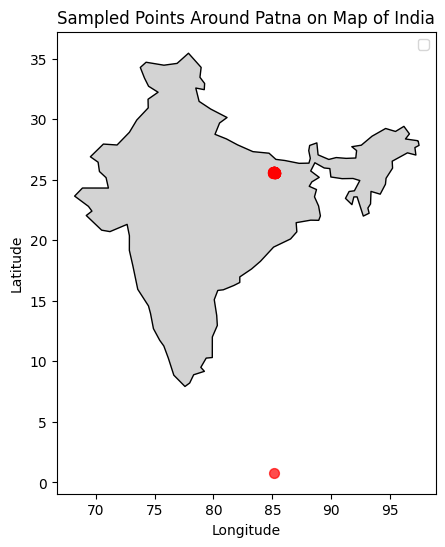

In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Sample DataFrame with latitudes and longitudes around Patna

# Sample 50 random points from the DataFrame
sampled_points = df.sample(50, random_state=42)

# Create a GeoDataFrame with Point geometries
geometry = [Point(xy) for xy in zip(sampled_points['long'], sampled_points['lat'])]
gdf = gpd.GeoDataFrame(sampled_points, geometry=geometry, crs="EPSG:4326")

# Load a basemap of India (shapefile needed)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

india = world[world['SOVEREIGNT'] == 'India']

# Plot the map with sampled points
fig, ax = plt.subplots(figsize=(8, 6))
india.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=50, alpha=0.7)

plt.title('Sampled Points Around Patna on Map of India')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

It seems as though Patna may be mixed in with Gurugram. Though based on this sample and without looking at it too closely, they do make sense.